
SCRATCH CNN.
In this notebook we performed benignant malignant classification with a CNN trained from scratch.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd "/content/drive/MyDrive/CI/"

/content/drive/MyDrive/CI


In [ ]:
!pip install import-ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=fa557f0bd41d7564a8a0de54c26046b4c4fcc9f3b37f28c5ca130f7bba278b3c
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [ ]:
import import_ipynb
import utility

import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from PIL import Image
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models 
from tensorflow.keras import layers
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

data_path='/content/drive/MyDrive/CI/numpy_data/'


# check hardware acceleration
device_name = tf.test.gpu_device_name()
print('GPU: ', device_name)

importing Jupyter notebook from utility.ipynb
GPU:  /device:GPU:0


Load and build the trainin set, setting 0 to benign class label and 1 to maglignant one

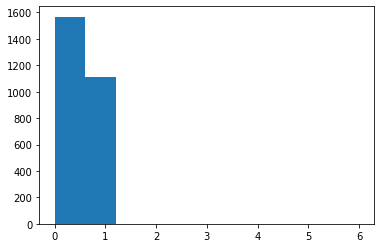

In [ ]:
images, labels= utility.load_training()
train_abnormal_imgs, train_bm_labels = utility.benignant_malignant_training_set_building(images, labels)
plt.hist(train_bm_labels,range=(0,6) )
plt.show()

Undersample the dataset

1568
1108
1568
Oversampling must be done on 460 elements of the second array.
Class 0: 1568
Class 1: 1568
(3136, 150, 150)


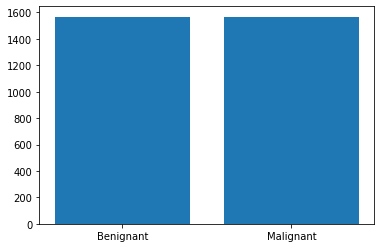

In [ ]:
#balance the datset
num_zeros = (train_bm_labels == 0).sum()
num_ones = (train_bm_labels == 1).sum()

print(num_zeros)
print(num_ones)

train_bm_imgs, train_bm_labels= utility.oversample(train_abnormal_imgs,train_bm_labels)
print(train_bm_imgs.shape)
#plt.hist(train_bm_labels,range=(0,6) )
#plt.show()



class_0 = len([labels for label in train_bm_labels if label == 0])
class_1 = len([labels for label in train_bm_labels if label == 1])

plt.bar(['Benignant', 'Malignant'], [class_0, class_1])
plt.title = 'Class Balancing after oversampling'
plt.show()

TEST SET GENERATION


In [ ]:
test_images, test_labels= utility.load_test()

test_bm_imgs,test_bm_labels = utility.benignant_malignant_test_set_building(test_images, test_labels)

#plt.hist(test_bm_labels,range=(0,6) )
#plt.show()



In [ ]:
def contrast(images):
  images = np.expand_dims(images, -1)
  contrast_img = []
  for elem in images:
    contrast_img.append(tf.image.adjust_contrast(elem, 2))
 
  contrast_img=np.array(contrast_img)
  contrast_img=np.squeeze(contrast_img, axis=-1)


  plt.imshow(np.squeeze(images, axis=-1)[0], cmap='gray')
  #plt.title('before contrast')
  plt.show()
  plt.imshow(contrast_img[0], cmap='gray')
  #plt.title('after contrast')
  plt.show()

  return contrast_img

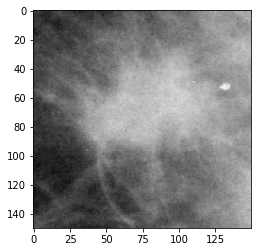

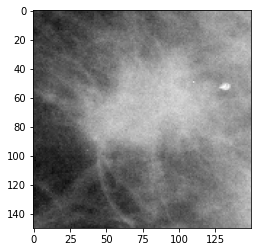

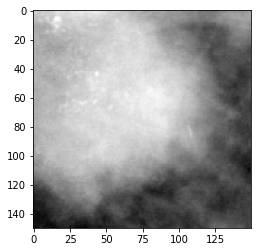

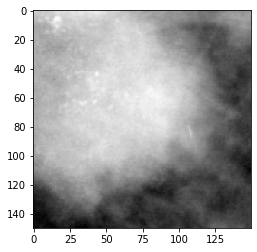

In [ ]:
##CONTRAST ADJUSTMENT

#add ,1 at the end of the shape
train_bm_imgs=contrast(train_bm_imgs)
test_bm_imgs=contrast(test_bm_imgs)

In [ ]:
print(train_bm_imgs[0])
print(train_bm_imgs.shape)
print(test_bm_imgs[0])
print(test_bm_imgs.shape)

scratch

In [ ]:
model = models.Sequential()


model.add(tf.keras.Input(shape=(150,150,1)))
#model.add(layers.experimental.preprocessing.RandomFlip(mode='horizontal', seed=123)) 
model.add(layers.experimental.preprocessing.RandomRotation(factor=0.25, seed=123, fill_mode='nearest')) #90degree

model.add(layers.Conv2D(32,(3,3),activation = 'relu' )) #32 filtri da 3x3, 3 channels    #num par= 3x3x3x32+32=896
model.add(layers.MaxPooling2D((2,2)))  #riduco la size della activation map della metà in pratica, ogni 4 entry ne prendo 1 (2 sulle coloenne, 2 sulle righe)
model.add(layers.Conv2D(64, (3,3), activation = 'relu' ))  #64filtri da 3x3, 32 channels  #num par 3x3x32x64+64= 18496
model.add(layers.MaxPooling2D(2,2)) #da 72 a 36
model.add(layers.Conv2D(128,(3,3), activation='relu'  )) #128 filtri da 3x3, 64 channels #num par 3x3x64x128+128=73856
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128,(3,3), activation='relu' )) #128 filtri da 3x3, 128 channels #num par 3x3x128x128+128=147584
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
#model.add(layers.Dropout(0.4))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.summary()

opt = keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_rotation (RandomRotat (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0

In [ ]:
EPOCHS=30
BATCH_SIZE=32
NORMALIZATION = 65536

#normalization of the images
train_datagen= ImageDataGenerator(rescale=1./NORMALIZATION)
test_datagen = ImageDataGenerator(rescale=1./NORMALIZATION)

#add ,1 at the end of the shape
train_bm_exp = np.expand_dims(train_bm_imgs, -1)
test_exp = np.expand_dims(test_bm_imgs, -1)

val_split = 0.2
X_train, X_val, y_train, y_val = train_test_split(train_bm_exp, train_bm_labels, test_size=val_split, stratify=train_bm_labels)

print(X_train.shape)

train_generator = train_datagen.flow(X_train, 
                                     y=y_train, 
                                     batch_size=BATCH_SIZE, 
                                     seed=123)

validation_generator = train_datagen.flow(X_val, 
                                          y=y_val, 
                                          batch_size=BATCH_SIZE, 
                                          seed=123)

test_generator =  test_datagen.flow(test_exp,
                                    y=test_bm_labels,
                                    batch_size=BATCH_SIZE,
                                    seed=123)
history = model.fit(
    train_generator, 
    epochs = EPOCHS,
    validation_data = validation_generator,
    )

(2508, 150, 150, 1)
Epoch 1/30
79/79 [==============================] - 10s 36ms/step - loss: 0.7493 - accuracy: 0.5181 - val_loss: 0.6881 - val_accuracy: 0.5127
Epoch 2/30
79/79 [==============================] - 2s 28ms/step - loss: 0.6898 - accuracy: 0.5663 - val_loss: 0.6700 - val_accuracy: 0.6083
Epoch 3/30
79/79 [==============================] - 2s 28ms/step - loss: 0.6601 - accuracy: 0.6126 - val_loss: 0.6418 - val_accuracy: 0.6035
Epoch 4/30
79/79 [==============================] - 2s 29ms/step - loss: 0.6355 - accuracy: 0.6253 - val_loss: 0.6281 - val_accuracy: 0.6226
Epoch 5/30
79/79 [==============================] - 2s 28ms/step - loss: 0.6392 - accuracy: 0.6209 - val_loss: 0.6191 - val_accuracy: 0.6146
Epoch 6/30
79/79 [==============================] - 2s 28ms/step - loss: 0.6259 - accuracy: 0.6360 - val_loss: 0.6125 - val_accuracy: 0.6274
Epoch 7/30
79/79 [==============================] - 2s 28ms/step - loss: 0.6211 - accuracy: 0.6549 - val_loss: 0.6067 - val_accuracy:

In [ ]:
dir_name ="/content/drive/MyDrive/CI/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model.save(os.path.join(dir_name,'xBM_SCRATCH_v5_3.h5'))

In [ ]:
utility.plot_history(history,'BM_SCRATCH_v5_3')

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)

print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)

11/11 [==============================] - 0s 14ms/step - loss: 0.6407 - accuracy: 0.5893
Test Accuracy: 0.5892857313156128
Test Loss: 0.640747606754303


Confusion matrix:
 [[ 98 121]
 [ 17 100]]

accuracy:
 0.5892857142857143

f2:
 0.725689404934688

report:
               precision    recall  f1-score   support

           0       0.85      0.45      0.59       219
           1       0.45      0.85      0.59       117

    accuracy                           0.59       336
   macro avg       0.65      0.65      0.59       336
weighted avg       0.71      0.59      0.59       336

AUC:
 0.6510947195878702


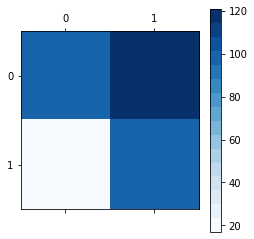

(0.6510947195878702, array([[ 98, 121],
        [ 17, 100]]), 0.5892857142857143, 0.725689404934688)

In [ ]:
test_set = test_exp/65536
test_predictions = model.predict(test_set) 
utility.do_evaluations(test_predictions, test_bm_labels)